# Set Up and libraries

In [4]:
# Reviews CSV
%%capture
#!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=mexudbu2&dl=0
#!mv Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=fqh0067i&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

In [5]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer

from concurrent.futures import ThreadPoolExecutor

In [6]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch


In [7]:
from tqdm import tqdm

# Data Preprocessing

In [8]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [9]:
df

,Unnamed: 0,user_id,gmap_id,rating,text,img_url,img_filename,state,rest_id
0,0,114453580163034019886,0x8644b59b8fe872e5:0x5e638876caa84cc3,5,They've developed an idea and made it their ow...,https://lh5.googleusercontent.com/p/AF1QipPCnJ...,Texas/0x8644b59b8fe872e5:0x5e638876caa84cc3.png,Texas,3818
1,1,103598690263545033047,0x86fe6dd0642d44eb:0xeaceade94f24cc15,5,All of this for just $8! A full meal replacer ...,https://lh5.googleusercontent.com/p/AF1QipOEfz...,Texas/0x86fe6dd0642d44eb:0xeaceade94f24cc15.png,Texas,3819
2,2,115640749244801394506,0x864c2161e9d8649b:0x22061733a9698bcb,5,Bushi is a pretty solid place all around.\nLot...,https://lh5.googleusercontent.com/p/AF1QipPyZW...,Texas/0x864c2161e9d8649b:0x22061733a9698bcb.png,Texas,3820
3,3,104421748665385525393,0x864e6571cdc9dbab:0xc1daa9eb0bf426ed,5,"Amazing place, fast and friendly service, grea...",https://lh5.googleusercontent.com/p/AF1QipNdGf...,Texas/0x864e6571cdc9dbab:0xc1daa9eb0bf426ed.png,Texas,3822
4,4,108976745273958544598,0x865c8940c0af4267:0xd79d5e7344028316,4,This was my 2nd time eating food from here. I...,https://lh5.googleusercontent.com/p/AF1QipOtUE...,Texas/0x865c8940c0af4267:0xd79d5e7344028316.png,Texas,3823
...,...,...,...,...,...,...,...,...,...
8329,8329,107001669308025856105,0x52cf9e4dba1cc63d:0x2639fd6150fc0ed1,5,My favorite place to stop between Fargo and Bi...,https://lh5.googleusercontent.com/p/AF1QipMa6z...,North_Dakota/0x52cf9e4dba1cc63d:0x2639fd6150fc...,North_Dakota,3816
8330,8330,110038188982373899263,0x52d78254d12f6543:0xf0331fcaa2a77b1,5,Enjoyed the food and friendly service. The pot...,https://lh5.googleusercontent.com/p/AF1QipOEyA...,North_Dakota/0x52d78254d12f6543:0xf0331fcaa2a7...,North_Dakota,3657
8331,8331,111587033401224572682,0x52d783155cb8e4d9:0x22661462c6bee9db,3,"It’s QDOBA, nothing much to write home about, ...",https://lh5.googleusercontent.com/p/AF1QipPLce...,North_Dakota/0x52d783155cb8e4d9:0x22661462c6be...,North_Dakota,324
8332,8332,107873738471499099380,0x5325e97b076a701d:0x1df9629bf123bbc9,5,Good food and fast service!,https://lh5.googleusercontent.com/p/AF1QipP2k9...,North_Dakota/0x5325e97b076a701d:0x1df9629bf123...,North_Dakota,3817


In [10]:
X = df[['user_id', 'rest_id', 'rating']]

In [12]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [14]:
print('Se cumple?',X_test.shape[0] + X_train.shape[0] == df.shape[0])
X_test.shape, X_train.shape

Se cumple? True


((1608, 3), (6430, 3))

In [15]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

In [ ]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [ ]:
metadata.keys()

In [ ]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [24]:
restaurants = pd.read_csv('restaurants.csv')

In [110]:
restaurants['categories'].value_counts()

,count
categories,
Restaurant,1370
Mexican restaurant,398
Chinese restaurant,147
Pizza restaurant,139
American restaurant,137
...,...
Cheesesteak restaurant;Sandwich shop;Hoagie restaurant;BBQ area;Restaurant;Soul food restaurant;Convenience store;Fast food restaurant,1
Hookah bar;Lounge;Restaurant,1
Taco restaurant;Beer garden,1


# Models

## Most popular

In [16]:
X_train.head()
# user_col = 1
# item_col = 8
# ratingcol = 3

,user_id,rest_id,rating
921,104821247123335993947,4656,5
322,110311159279673868147,4117,5
7362,103123121604121592049,3121,4
5106,117236005272924483096,5832,5
6416,111573673274766827201,6839,4


In [17]:
model_mp = pyreclab.MostPopular(
    dataset= 'reviews_train.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2
)

In [18]:
model_mp.train(progress=True)

In [100]:
mp_reclist10, mp_map10, mp_ndcg10 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2,
    topn = 10,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

mp_reclist20, mp_map20, mp_ndcg20 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2,
    topn = 20,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

### Ejemplo

In [101]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if str(index) not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [102]:
random_user = '112293856248240959045'
show_recommendations(
    random_user,                # Random user ...
    mp_reclist10[random_user]
)

,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
8,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
9,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant


In [103]:
show_recommendations(
    random_user,                # Random user ...
    mp_reclist20[random_user]
)

,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
8,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
9,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...


### Metricas

In [106]:
mp_map10, mp_ndcg10, mp_map20, mp_ndcg20

(0.020280666606522155,
 0.029094679199922178,
 0.021236518312288427,
 0.033375352901938625)

## Random

In [64]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def evaluate_model(random_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        reclist = random_reclist[u]
        rel_vector = [np.isin(user_items_test[u], reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_items_test[u]))

    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_ap, mean_ndcg


In [55]:
user_items_train = {}
itemset = set()

for row in X_train.itertuples():
    if row[1] not in user_items_train:
        user_items_train[row[1]] = []

    user_items_train[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))


user_items_test = {}

for row in X_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [92]:
random_reclist10 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=10))
    random_reclist10[user_id] = list([str(x) for x in reclist])

In [91]:
random_reclist20 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=20))
    random_reclist20[user_id] = list([str(x) for x in reclist])

### Ejemplo

In [93]:
random_reclist10[random_user]

['3814',
 '5286',
 '5481',
 '1068',
 '6448',
 '2322',
 '6547',
 '1748',
 '5586',
 '4028']

In [94]:
show_recommendations(random_user, random_reclist10[random_user])

,name,description,categories
0,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
1,Mediterraneum Street Food,Health-conscious Mediterranean menu served in ...,Mediterranean restaurant;Tapas restaurant;Span...
2,Casa Viva Indian & Mexican Cuisine,NaN,Mexican restaurant;Indian restaurant
3,Trapper's Kettle,NaN,Restaurant
4,QuikTrip,"Convenience store chain supplying snacks, sand...",Breakfast restaurant;Gas station;Beer store;Sn...
5,Carr Brothers Gathering Place,NaN,American restaurant;Bar & grill
6,Carlos Brazilian International Cuisine,Wide-ranging Brazilian dishes in classy quarte...,Brazilian restaurant
7,Sweetwater Tavern,Cowboy-themed microbrewery offering fresh-brew...,Steak house;Bar;Tex-Mex restaurant;American re...
8,Zen bistro & wine bar,"Stylish bistro with sushi, Asian small plates ...",Wine bar;Sushi restaurant;Asian restaurant;Ram...
9,The Cutting Edge Cafe,"American cafe offering panini, salads, housema...",Cafe;Restaurant


In [95]:
show_recommendations(random_user, random_reclist20[random_user])

,name,description,categories
0,Los Angeles Crepes,NaN,Crêperie;Fast food restaurant
1,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
2,Tasty Thousand Restaurant,NaN,Mandarin restaurant;Chinese restaurant;Soup re...
3,Mingle's Mango,NaN,Chinese restaurant
4,Pizza & Pints,NaN,Pizza restaurant
5,Midori 5,Familiar Japanese kitchen entrees & creative s...,Japanese restaurant
6,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
7,T & L's BAR-B-Q AND Soul Food Catering,NaN,Barbecue restaurant
8,Fireside Cafe,NaN,Restaurant;Pizza restaurant
9,Tight Tacos Maui,NaN,Mexican restaurant


### Metricas

In [96]:
mean_ap, mean_ndcg = evaluate_model(random_reclist10, n=10)
print("nDCG@10", mean_ndcg)
print("MAP@10", mean_ap)


nDCG@10 0.008939974457215836
MAP@10 0.0008939974457215838


In [97]:
mean_ap, mean_ndcg = evaluate_model(random_reclist20, n=20)
print("nDCG@10", mean_ndcg)
print("MAP@10", mean_ap)


nDCG@10 0.010114585937609435
MAP@10 0.0005427841634738187


## Multimodal Recsys (Cornac Library)

In [ ]:
# * Codigo obtenido del practico 4 *

modelo_escogido = 'vgg19' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
imgs_model_width, imgs_model_height = 224, 224

In [ ]:
df_sample = df

In [ ]:
print(df_sample.value_counts('rating'))
print(df_sample.shape)

rating
5    5280
4    1564
3     496
1     436
2     262
Name: count, dtype: int64
(8038, 7)


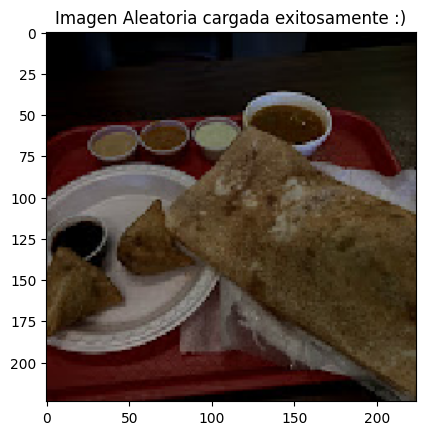

In [ ]:
FOLDER = 'reviews'
files = df_sample['img_filename'].tolist()
idx =  random.randint(0, len(files))
original = load_img(f'{FOLDER}/{files[idx]}', target_size=(imgs_model_width, imgs_model_height))
plt.title("Imagen Aleatoria cargada exitosamente :)")
plt.imshow(original)
plt.show()


In [ ]:
D_IE = 0 # Download Images Embeddings

In [ ]:
# En una lista iremos guardando cada imagen preprocesada
if D_IE:
    all_images = []
    for f in files_sample:
        prefix = FOLDER
        filename = f'{prefix}/{f}'
        original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        all_images.append(image_batch)

    images = np.vstack(all_images)

    processed_imgs = preprocess_input(images.copy()) # preprocesamos todas las imagenes
    imgs_features = feat_extractor.predict(processed_imgs)
    print("features extraidos exitosamente! :)")
    print(imgs_features.shape)
    with open('imgs_features_1.npy', 'wb') as file: # guardamos los embeddings
        np.save(file, imgs_features)
else:
    with open('imgs_features.npy', 'rb') as file:
        imgs_features = np.load(file)

In [ ]:
userset = set(df_sample['user_id'].tolist())
itemset = set(df_sample['gmap_id'].tolist())
user_to_idx = {user: idx for idx, user in enumerate(userset)}
item_to_idx = {item: idx for idx, item in enumerate(itemset)}

idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}


In [ ]:
# Text modality configurations
VOCAB_SIZE = 5000
item_text_modality = TextModality(
    corpus=df_sample['text'].tolist(),
    id_map=item_to_idx,
    max_vocab=VOCAB_SIZE,
    tokenizer=BaseTokenizer()
)



In [ ]:
# Images configurations
item_image_modality = ImageModality(
    features=imgs_features,
    ids=item_to_idx
    )

In [ ]:
uir_list = df[['user_id', 'gmap_id', 'rating']].values.tolist()

In [ ]:
SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()


In [ ]:
ratio_split = RatioSplit(
    data=uir_list,
    test_size=0.3,
    rating_threshold=3.5,
    item_text=item_text_modality, # agregamos la modalidad de texto
    item_image=item_image_modality, # agregamos la modalidad de imagen
    exclude_unknowns=False,
    seed=SEED,
    verbose=VERBOSE,
)



rating_threshold = 3.5
exclude_unknowns = False
---
Training data:
Number of users = 5182
Number of items = 5626
Number of ratings = 5626
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 7254
Number of items = 8038
Number of ratings = 2412
Number of unknown users = 2072
Number of unknown items = 2412
---
Total users = 7254
Total items = 8038


In [ ]:
imgs_features.shape

(8038, 4096)

In [ ]:
# baseline MostPopular
most_pop = cornac.models.MostPop()

# modelo CDL (Collaborative Deep Learning)
cdl = cornac.models.CDL(
    k=50, # dimension factor latente
    autoencoder_structure=[200],  # N° de neuronas de la capa code/decoder para SDAE
    vocab_size=VOCAB_SIZE, # cantidad maxima de vocabulario
    act_fn='tanh',
    max_iter=20,
    batch_size=1024,
    seed=SEED,
    verbose=VERBOSE
)
# modelo VBPR (Visual Bayesian Personalized Ranking)
vbpr = cornac.models.VBPR(
    k=10, # dimension de gamma en el espacio latente
    k2=40,  # dimension de theta en el espacio latente
    n_epochs=20,
    use_gpu=USE_GPU,
    batch_size=1024,
    seed=SEED,
    verbose=VERBOSE
)

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [ ]:
print(torch.cuda.is_available()) # Debe estar en True para poder usar LLaVa

True


In [ ]:
# Importamos los modelos a usar
# LLaVa
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
# all-MiniLM-L6-v2
# encoder = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

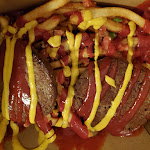

'The image features a close-up of a hamburger with a generous amount of ketchup and mustard. The hamburger is'

In [ ]:
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
get_description(image)

In [ ]:
img_description = {}
for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
    img_path = f'reviews/{row.img_filename}'
    description = get_description(Image.open(path))
    img_description[row.img_filename] = description

with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
    json.dump(img_description, zipfile)

Processing rows:   1%|          | 55/8038 [02:17<5:32:56,  2.50s/it]


KeyboardInterrupt: 

In [ ]:
def save_images_descriptions(df):
    img_description = {}

    # Preprocesamiento de imágenes y descripciones
    with ThreadPoolExecutor(max_workers=50) as executor:
        for description in tqdm(executor.map(get_description,
                            [Image.open(f'reviews/{row.img_filename}') for _, row in df.iterrows()]),
                            total=df.shape[0]):
            img_description[row.img_filename] = description

    # Guardar las descripciones en un archivo comprimido
    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)

save_images_descriptions(df)

  0%|          | 0/8038 [00:09<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 25.06 MiB is free. Process 11642 has 14.72 GiB memory in use. Of the allocated memory 13.26 GiB is allocated by PyTorch, and 837.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
user_interactions = {}
for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
    user_id = row.user_id

    business_name = f"RESTAURANT NAME: {idx2metadata[row.gmap_id]['name']}"
    categ = ", ".join(idx2metadata[row.gmap_id]["category"])

    rating = f"REVIEW RATING: {row.rating}"
    review = f"REVIEW: {row.text}"

    path = f"reviews/{row.img_filename}"
    summary = f"IMAGE REVIEW SUMMARY: {get_description(Image.open(path))}"

    info = (business_name, categ, rating, review, summary)

    if not user_interactions.get(user_id):
        user_interactions[user_id] = [info]
    else:
        user_interactions[user_id].append(info)

Processing rows:   1%|          | 41/8038 [01:55<6:14:20,  2.81s/it]


KeyboardInterrupt: 

In [ ]:
with open("user_interactions.npy", )

In [ ]:
user_interactions

{'114453580163034019886': [('RESTAURANT NAME: Golden Castle',
   'Restaurant',
   'REVIEW RATING: 5',
   "REVIEW: They've developed an idea and made it their own, and expanding it pastrami brined hot dogs and Sichuan dry rub chicken nuggets. A little bit of work getting there, but worth it!",
   'IMAGE REVIEW SUMMARY: The image features a person holding a half-eaten sandwich, with a bite taken out of it. The sandwich is placed on a')]}

In [ ]:
for user, history in user_interactions.values():
    print(history)
    break

## Metricas

In [2]:
def get_popularity(item_id):
    '''
    Retorna la popularidad de un item dado su ID. Esta se calcula como

    ->  pop_i = #Interacciones sobre el item / total de interacciones

    Para el caso que el item no exista, entonces lo que hacemos es tomar como
    popularidad base pop_i = 1 / total de interacciones
    '''
    if item_id not in df_train.itemID.values:
        popularity = 1 / len(df_train) # retornamos el valor mas bajo ya que seria un item "nuevo"
        return popularity # si el item no esta en train, retornamos 1 evitar errores ...
    item_count = df_train[df_train.itemID == item_id]['popularity'].values[0]
    popularity = item_count /  len(df_train)
    return popularity

def get_style(item_id):
    ''' Retorna el styleID de un item dado su ID '''
    return df_style[df_style.itemID == item_id]['styleID'].values[0]



def diversity(recommend_list):
    ''' Retorna el valor de diversidad en una lista de recomendación.
    Utilizamos como una medida de similitud binaria en la comparacion de
    styleID entre dos pares de items '''
    value = 0
    length = len(recommend_list)

    for item_1 in recommend_list:
        item_1_style = get_style(item_1)

        for item_2 in recommend_list:
            if item_1 == item_2:
                continue

            item_2_style = get_style(item_2)

            if item_1_style == item_2_style:
                value += 1

    return (value * 2) / (length * (length - 1))

def mean_diversity(model_recommend_list):
    ''' Funcion que retorna la diversidad promedio del dataset. Consulta
    la diversidad de la lista recomendada por cada usuario (ILS) y luego
    sacamos el promedio de los valores.
    '''
    ils_per_user = []

    for user, recommend_list in model_recommend_list.items():
        ils = diversity(recommend_list)
        ils_per_user.append(ils)

    return np.mean(ils_per_user)

def inverse_log_popularity(recommend_list):
    ''' Recibe la lista de recomendacion de 10 items de un usuario
    y retorna el inverso de la popularidad total de la lista
    '''
    value = 0
    for item_id in recommend_list:
        popularity = get_popularity(item_id)
        value += np.log(1 / popularity)
    return (1 / len(recommend_list)) * value

def novelty(model_recommend_list):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    result = 0
    users = len(model_recommend_list.keys())

    for user, recommend_list in model_recommend_list.items():
        result += inverse_log_popularity(recommend_list)

    return (1 / users) * result

In [ ]:
def get_metrics(n):
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


In [ ]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/6 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 0.8337 | 0.0000 | 0.0001 | 0.0001 | 0.0007 |  0.0005 |       0.0001 |    0.0005 |    0.0005 |   4.4828
CDL     | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0002 |  0.0000 |       0.0000 |    0.0000 |   84.6468 |   5.3111
VBPR    | 3.0857 | 0.4959 | 0.0003 | 0.0014 | 0.0015 |  0.0008 |       0.0002 |    0.0015 |   12.5501 |   9.9196



In [ ]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=20))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/6 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/2412 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2317 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@20 |    MAP |    MRR | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0007 |  0.0005 |       0.0000 |    0.0005 |    0.0012 |   4.6071
CDL     | 0.8337 | 0.0000 | 0.0000 | 0.0001 | 0.0002 |  0.0000 |       0.0000 |    0.0000 |   80.7129 |   4.8177
VBPR    | 2.8277 | 0.4924 | 0.0004 | 0.0018 | 0.0018 |  0.0018 |       0.0002 |    0.0045 |   16.0080 |   9.0484



# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master

In [ ]:
# [TODO]: Descargar metadata ...

In [ ]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'url' : [],
        'categories': []

    }
    for d in metadata:
        if d['gmap_id'] not in reclist: continue
        categories = ", ".join(d['category'])

        rec_business_cols['name'].append(d['name'])
        rec_business_cols['description'].append(d['description'])
        rec_business_cols['url'].append(d['url'])

        rec_business_cols['categories'].append(categories)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [ ]:
user_3 = random.choice(list(idx_to_user.keys()))
print("ID Usuario: ", idx_to_user[user_3])

ID Usuario:  101703766448840431953


In [ ]:
# Recomendaciones realizadas usando VBPR
user3_reclist = get_reclist(user_3, vbpr, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

Pandas(Index=1629, user_id='108110045783073684834', gmap_id='0x80dcb70a135b882d:0x100744bda56151d', rating=4, text='So I would have given this place three stars if we were just comparing food but the service was good so... girl in red sweater, you did good.\n\nI took forever to decide what I wanted to eat. I usually get falafel but sometimes places make it too salty and I can’t eat it. If you like salty food this is a great place to go.\n\nThe lamb chops were great and seasoned well however the rice it came with was extremely salty and I couldnt eat it. The other side dishes were amazing and went super well with my lamb chops even though I felt like the lamb chops were kind of small for the price. The TVs are really loud inside of the restaurant and it echoes so if you’re OK with loud noises there is seating inside.\n\nThe pistachio baklava was a little disappointing for me because I am used to going to Persian markets and finding baklava doused in honey. This one was a little dry I do

In [ ]:
# Recomendaciones realizadas usando Most Popular
user3_reclist = get_reclist(user_3, most_pop, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

In [ ]:
# Recomendaciones realizadas usando CDL
user3_reclist = get_reclist(user_3, cdl, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)